# Exploration of Flight Delay Data

## Section 1: Data Import, Manipulation, and Exploration
### This initial section explores the data and cleans it for later modeling. This section also serves to complete the requirements for the Capstone Milestone report

In [1]:
#Import of basic libraries for data manipulation and plotting
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

#### Data consists of flight performance data from 2014 and the first half of 2015 with variables such as schedule departure date & time, airline carrier, origin airport, scheduled arrival time etc. with the dependent variable of ARR_DEL_15 (a flight delayed more than 15 minutes is considered delayed). This information was split into three separate CSV files. 

#### Weather data was also provided by location and in 15 minute increments, however, this set is not complete with respect to all information in the flight time performance data.

#### The codes file was created manually by exporting flight city information from both the performance and weather data. Matches between the ICAO codes and IATA were either obvious or had to be researched online. 

In [2]:
# Training files are divided into three separate files in six month increments
temp_train_2014_1 = pd.read_csv('CAX_Train_2014_Jan_to_Jun.csv')
temp_train_2014_2 = pd.read_csv('CAX_Train_2014_Jul_to_Dec.csv')
temp_train_2015 = pd.read_csv('CAX_Train_2015.csv')

# Read in the weather file
weather = pd.read_csv('weather.csv')

# The codes file is a manual matching I created between the IATA codes in the 
# training files and the ICAO codes in the weather file. Multiple IATA codes can 
# join to the same ICAO codes based on proximity to cities. City names in the 
# training files can be truncated and often did not match the weather file. 
# If the matching wasn't obvious based on the IATA and ICAO codes then IATA 
# code were looked up in Google to determine thenearest ICAO city.
codes = pd.read_csv('training_weather_cities_joined.csv')

In [3]:
# Combine all of the training files into one dataframe
training = pd.concat([temp_train_2014_1, temp_train_2014_2, temp_train_2015], ignore_index=True)

In [4]:
print training.dtypes
print "Number of columns in the flight data:",len(training.dtypes)

id                    int64
YEAR                  int64
QUARTER               int64
MONTH                 int64
DAY_OF_MONTH          int64
DAY_OF_WEEK           int64
FL_DATE              object
UNIQUE_CARRIER       object
TAIL_NUM             object
FL_NUM                int64
ORIGIN               object
ORIGIN_AIRPORT_ID     int64
ORIGIN_CITY_NAME     object
ORIGIN_STATE_ABR     object
DEST                 object
DEST_AIRPORT_ID       int64
DEST_CITY_NAME       object
DEST_STATE_ABR       object
CRS_DEP_TIME          int64
DEP_TIME_BLK         object
TAXI_IN               int64
CRS_ARR_TIME          int64
ARR_TIME_BLK         object
ARR_DEL15             int64
CRS_ELAPSED_TIME      int64
DISTANCE              int64
DISTANCE_GROUP        int64
dtype: object
Number of columns in the flight data: 27


#### Additional time features are added in order to identify possible trends 

In [5]:
# Create day of year, week of year, and hour features from the flight date
training['DAY_OF_YEAR'] = pd.to_datetime(training['FL_DATE'], 
                                         errors='coerce').dt.dayofyear.astype(int)
training['WEEK_OF_YEAR'] = pd.to_datetime(training['FL_DATE'], 
                                          errors='coerce').dt.weekofyear.astype(int)
training['hour'] = training['CRS_DEP_TIME'].map(lambda x: int(str(int(x)).zfill(4)[:2]))

In [6]:
# This array defines the dates of holidays in 2014 and 2015 which were looked up on the internet
holidays = [
        date(2014, 1, 1), date(2014, 1, 20), date(2014, 5, 26), date(2014, 7, 4),
        date(2014, 9, 1), date(2014, 11, 27), date(2014, 12, 25),
        date(2015, 1, 1), date(2015, 1, 19), date(2015, 5, 25), date(2015, 7, 4),
        date(2015, 9, 7), date(2015, 11, 26), date(2015, 12, 25)
     ]

#Function that gives the number of days from a date to the nearest holiday
def days_from_nearest_holiday(year, month, day):
  d = date(year, month, day)
  x = [(abs(d-h)).days for h in holidays]
  return min(x)

# Create the days from holiday feature using the defined function
training['days_from_holidays'] = [days_from_nearest_holiday(r.YEAR, r.MONTH, r.DAY_OF_MONTH) \
                                  for i,r in training.iterrows()]

## Flight Performance Data
#### Below are various charts to discover possible variables impacting flight delays.

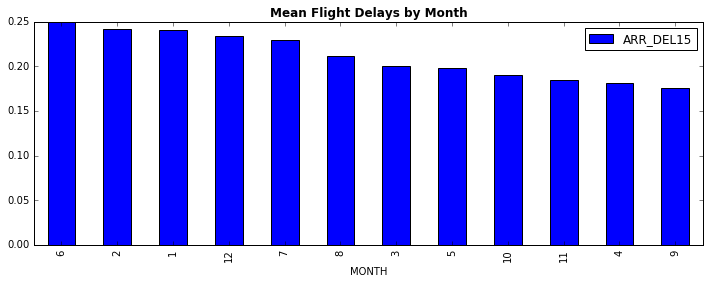

In [7]:
# Compute average number of delayed flights per month
grouped = training[['ARR_DEL15', 'MONTH']].groupby('MONTH').mean()

#Sort months from highest to lowest based on mean flight delays
grouped2 = grouped.sort(['ARR_DEL15'], ascending=False)

# plot average delays by month
grouped2.plot(kind='bar')
plt.title('Mean Flight Delays by Month', fontweight="bold")

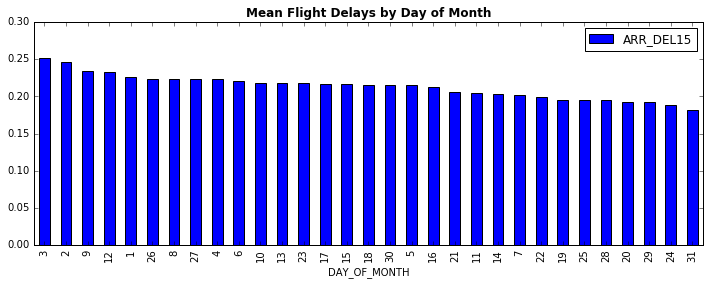

In [8]:
# Compute average number of delayed flights per month
grouped = training[['ARR_DEL15', 'DAY_OF_MONTH']].groupby('DAY_OF_MONTH').mean()

#Sort days from highest to lowest based on mean flight delays
grouped2 = grouped.sort(['ARR_DEL15'], ascending=False)

# plot average delays by month
grouped2.plot(kind='bar')
plt.title('Mean Flight Delays by Day of Month', fontweight="bold")

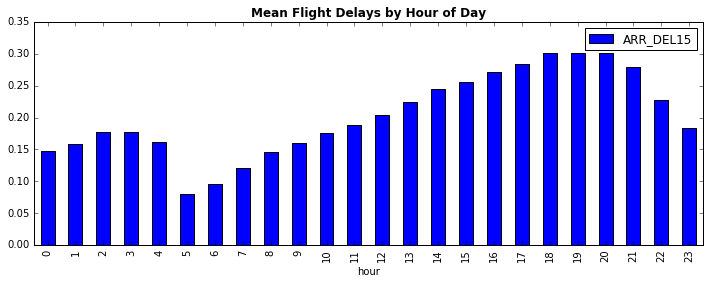

In [9]:
# Compute average number of delayed flights by hour
grouped = training[['ARR_DEL15', 'hour']].groupby('hour').mean()

# plot average delays by hour of day
grouped.plot(kind='bar')
plt.title('Mean Flight Delays by Hour of Day', fontweight="bold")

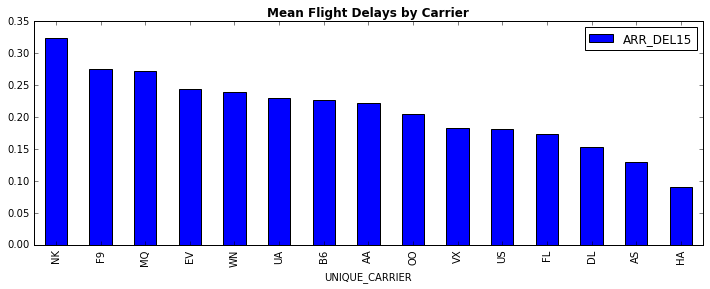

In [10]:
# Compute average number of delayed flights per carrier and filter based on carriers
# with more than 15 records
grouped = training[['ARR_DEL15', 'UNIQUE_CARRIER']] \
    .groupby('UNIQUE_CARRIER').filter(lambda x: len(x)>15)
grouped1 = grouped.groupby('UNIQUE_CARRIER').mean()

# display all carriers by delay
grouped1.sort(['ARR_DEL15'], ascending=False).plot(kind='bar')
plt.title('Mean Flight Delays by Carrier', fontweight="bold")

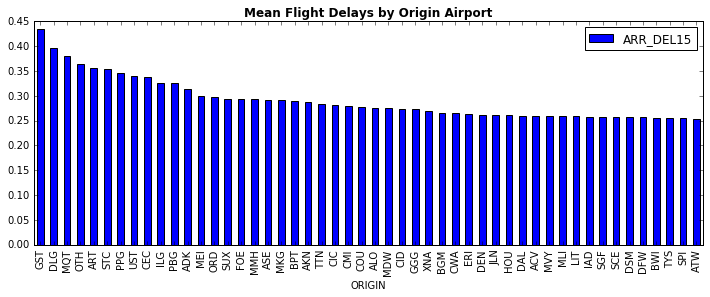

In [11]:
# Compute average number of delayed flights per origin airport based on airports
# with more than 15 records
grouped = training[['ARR_DEL15', 'ORIGIN']].groupby('ORIGIN').filter(lambda x: len(x)>15)
grouped1 = grouped.groupby('ORIGIN').mean()

# display top 50 origin airports by delay
grouped1.sort(['ARR_DEL15'], ascending=False)[:50].plot(kind='bar')
plt.title('Mean Flight Delays by Origin Airport', fontweight="bold")

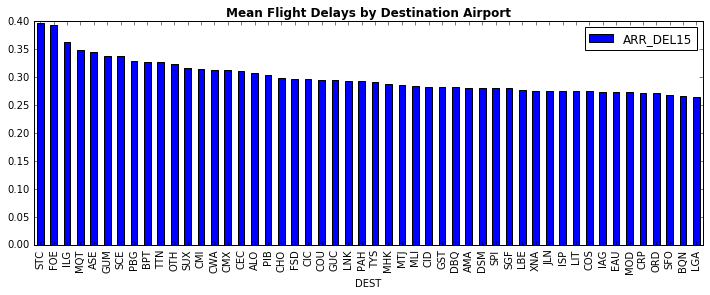

In [12]:
# Compute average number of delayed flights per destination airport
grouped = training[['ARR_DEL15', 'DEST']].groupby('DEST').filter(lambda x: len(x)>15)
grouped1 = grouped.groupby('DEST').mean()

# display top 50 origin airports by delay
grouped1.sort(['ARR_DEL15'], ascending=False)[:50].plot(kind='bar')
plt.title('Mean Flight Delays by Destination Airport', fontweight="bold")

From the above charts, it appears that some of the features have a definite impact on flight delays. 

Flights delays by hour of day dramatically increase throughout the day peaking at around 8pm. Possibly this is due to problems building on each other during the course of the day.

It's also obvious that certain carriers are more prone to delays. Origin airport appears to impact possible delays more than destination airports, but both charts start to even out quickly based on the top 50's trend.

Finally, both month of year and day of month don't appear to have much variation when considering flight delays.

## Weather features

#### Weather data is cleaned and manipulated below. It is then grouped by week of year and joined to the flight performance dataframe for both origin and destination airports.

In [13]:
# Creating week of year field in order to group weather events by week
weather['week_of_year'] = pd.to_datetime(weather['date'], errors='coerce').dt.weekofyear.astype(
    int)

# Some basic munging of weather fields
weather.events.fillna(-1, inplace=True)
weather.conditions.fillna(-1, inplace=True)
weather.gust_speed_mph.replace('-', -1, inplace=True)
weather.gust_speed_mph.fillna(-1, inplace=True)
weather.gust_speed_mph = pd.to_numeric(weather.gust_speed_mph, errors='coerce')
weather.wind_speed_mph.replace('Calm', 0, inplace=True)
weather.wind_speed_mph.fillna(-1, inplace=True)
weather.wind_speed_mph = pd.to_numeric(weather.wind_speed_mph, errors='coerce')

# Changing to weather types in the events field to numeric values based on the likelihood 
# of causing delays (e.g. Events involving ice have a higher values)
weather.events.replace(['Fog', 'Fog-Hail-Thunderstorm', 'Fog-Rain', 'Fog-Rain-Hail-Thunderstorm', 
                        'Fog-Rain-Snow', 'Fog-Rain-Thunderstorm', 
                        'Fog-Rain-Thunderstorm-Tornado', 'Fog-Snow', 'Fog-Snow-Thunderstorm', 
                        'Fog-Thunderstorm', 'Hail', 'Hail-Thunderstorm', 'Rain', 'Rain-Hail', 
                        'Rain-Hail-Thunderstorm', 'Rain-Snow', 'Rain-Snow-Thunderstorm', 
                        'Rain-Thunderstorm', 'Rain-Thunderstorm-Tornado', 'Rain-Tornado', 
                        'Snow', 'Snow-Hail', 'Snow-Thunderstorm', 'Snow-Tornado', 'Thunderstorm', 
                        'Thunderstorm-Tornado', 'Tornado'], [10, 80, 20, 80, 60, 50, 100, 60, 
                         60, 50, 80, 80, 20, 80, 80, 60, 60, 50, 100, 100, 60, 80, 60, 100, 
                         50, 100, 100], inplace=True)

# As with the events field, changing the conditions field to numeric values based on the 
# likelihood of causing delays
weather.conditions.replace(['Unknown', 'Clear', 'Overcast', 'Partly Cloudy', 'Drizzle', 
                            'Scattered Clouds', 'Mostly Cloudy', 'Haze', 'Mist', 
                            'Patches of Fog', 'Rain', 'Shallow Fog', 'Low Drifting Snow', 
                            'Rain Showers', 'Light Blowing Snow', 'Light Drizzle', 'Light Fog', 
                            'Light Hail', 'Light Ice Pellets', 'Light Low Drifting Snow', 
                            'Light Mist', 'Light Rain', 'Light Rain Showers', 'Light Sand', 
                            'Light Small Hail Showers', 'Light Smoke', 'Light Snow', 
                            'Light Snow Grains', 'Light Snow Showers', 'Light Thunderstorm', 
                            'Light Thunderstorms and Rain', 'Light Thunderstorms and Snow', 
                            'Light Thunderstorms with Hail', 
                            'Light Thunderstorms with Small Hail', 'Heavy Blowing Snow', 
                            'Heavy Drizzle', 'Heavy Freezing Drizzle', 'Heavy Freezing Fog', 
                            'Heavy Freezing Rain', 'Heavy Ice Pellets', 'Heavy Rain', 
                            'Heavy Rain Showers', 'Heavy Small Hail', 'Heavy Snow', 
                            'Heavy Snow Showers', 'Heavy Thunderstorm', 
                            'Heavy Thunderstorms and Rain', 'Heavy Thunderstorms and Snow', 
                            'Heavy Thunderstorms with Hail', 
                            'Heavy Thunderstorms with Small Hail', 'Ice Crystals', 
                            'Ice Pellets', 'Funnel Cloud', 'Blowing Sand', 'Blowing Snow', 
                            'Thunderstorm', 'Thunderstorms and Rain', 'Thunderstorms and Snow', 
                            'Thunderstorms with Hail', 'Thunderstorms with Small Hail', 
                            'Volcanic Ash', 'Widespread Dust', 'Sand', 'Sandstorm', 
                            'Small Hail', 'Small Hail Showers', 'Smoke', 'Snow', 'Snow Grains', 
                            'Snow Showers', 'Squalls', 'Fog', 'Freezing Rain', 'Hail', 
                            'Light Freezing Drizzle', 'Light Freezing Fog', 
                            'Light Freezing Rain'], [-1, 0, 0, 0, 10, 0, 0, 0, 0, 10, 10, 
                             10, 30, 10, 30, 10, 10, 50, 70, 30, 0, 10, 10, 30, 50, 20, 30, 
                             70, 30, 20, 20, 40, 60, 60, 80, 20, 70, 70, 90, 80, 20, 20, 70, 
                             80, 80, 50, 30, 80, 80, 80, 70, 70, 90, 70, 70, 40, 30, 70, 80, 
                             80, 100, 20, 60, 80, 60, 70, 20, 60, 60, 60, 70, 10, 80, 50, 60, 
                             50, 80], inplace=True)

In [14]:
# Grouping the weather features by week of year and airport
weather_group = weather.groupby( [ 'airport_code', 'week_of_year'] ).mean()
weather_group = weather_group.reset_index()
weather_group = weather_group.drop('zip', 1)
weather_group.fillna(-1, inplace=True)

In [15]:
# Merge the codes file to get the IACO codes for the origin IATA code
training = pd.merge(training, codes[['ORIGIN', 'city', 'airport_code']], 
                    left_on='ORIGIN', right_on='ORIGIN')
training.rename(columns={'city': 'origin_city', 'airport_code': 'origin_icao_code'}, inplace=True)

# Merge the codes file to get the IACO codes for the destination IATA code
training = pd.merge(training, codes[['ORIGIN', 'city', 'airport_code']], 
                    left_on='DEST', right_on='ORIGIN')
training.rename(columns={'city': 'dest_city', 'airport_code': 'dest_icao_code', 
                         'ORIGIN_x': 'ORIGIN'}, inplace=True)
training = training.drop('ORIGIN_y', 1)

# Merge the weather data with the training data on the origin and week of year
training = pd.merge(training, weather_group, left_on=['origin_icao_code', 'WEEK_OF_YEAR'], 
                    right_on=['airport_code', 'week_of_year'], how='left')
training.rename(columns={'conditions': 'orig_conditions', 'airport_code': 'orig_airport_code', 
                         'week_of_year': 'orig_week_of_year', 
                         'temperature_f': 'orig_temperature_f', 
                         'dew_point_f': 'orig_dew_point_f', 'humidity': 'orig_humidity', 
                         'sea_level_pressure_in': 'orig_sea_level_pressure_in', 
                         'visibility_mph': 'orig_visibility_mph', 
                         'wind_speed_mph': 'orig_wind_speed_mph', 
                         'gust_speed_mph': 'orig_gust_speed_mph', 
                         'precipitation_in': 'orig_precipitation_in', 
                         'events': 'orig_events', 'wind_dir_degrees': 'orig_wind_dir_degrees'\
                        }, inplace=True)

# Merge the weather data with the training data on the destination and week of year
training = pd.merge(training, weather_group, left_on=['dest_icao_code', 'WEEK_OF_YEAR'], 
                    right_on=['airport_code', 'week_of_year'], how='left')
training.rename(columns={'conditions': 'dest_conditions', 'airport_code': 'dest_airport_code', 
                         'week_of_year': 'dest_week_of_year', 
                         'temperature_f': 'dest_temperature_f', 
                         'dew_point_f': 'dest_dew_point_f', 'humidity': 'dest_humidity', 
                         'sea_level_pressure_in': 'dest_sea_level_pressure_in', 
                         'visibility_mph': 'dest_visibility_mph', 
                         'wind_speed_mph': 'dest_wind_speed_mph', 
                         'gust_speed_mph': 'dest_gust_speed_mph', 
                         'precipitation_in': 'dest_precipitation_in', 
                         'events': 'dest_events', 'wind_dir_degrees': 'dest_wind_dir_degrees'\
                        }, inplace=True)

training.fillna(-1, inplace=True)

### Below are some charts exploring the impact of some weather features.

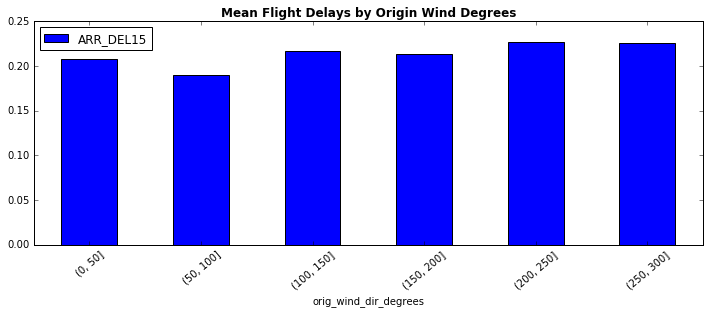

In [16]:
#Grouping wind degrees into bins and getting the mean delay
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_wind_dir_degrees, \
                                     np.arange(0, 350, 50))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Wind Degrees', fontweight="bold")

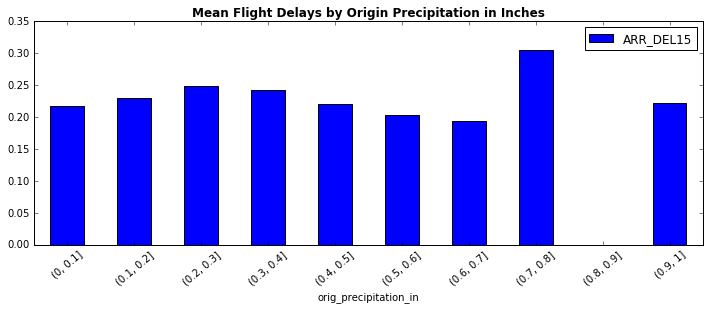

In [17]:
#Grouping inches of precipitation into bins and getting the mean delay
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_precipitation_in, \
                                     np.arange(0, 1.1, .1))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Precipitation in Inches', fontweight="bold")

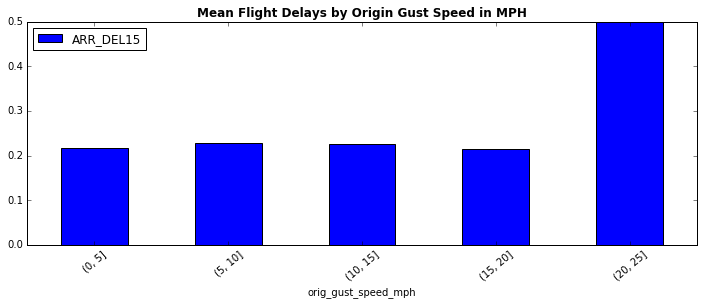

In [18]:
#Grouping gust speed into bins and getting the mean delay
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_gust_speed_mph, \
                                     np.arange(0, 30, 5))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Gust Speed in MPH', fontweight="bold")

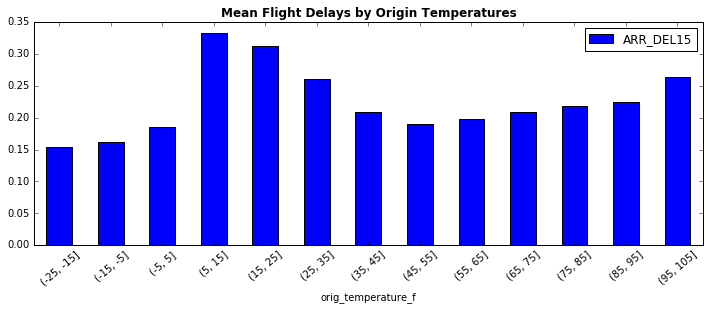

In [19]:
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_temperature_f, \
                                     np.arange(-25, 110, 10))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Temperatures', fontweight="bold")

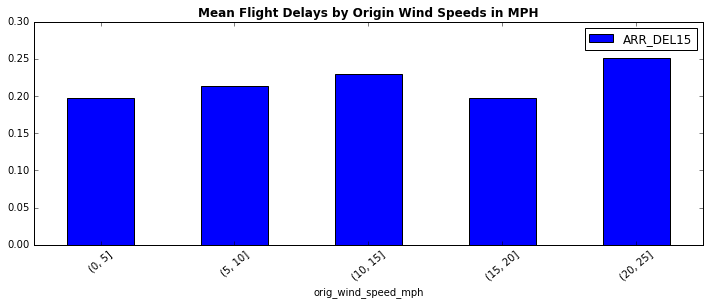

In [20]:
#Grouping wind speed into bins and getting the mean delay
grouped = training[['ARR_DEL15']].groupby(pd.cut(training.orig_wind_speed_mph, \
                                     np.arange(0, 30, 5))).mean()

grouped.plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Mean Flight Delays by Origin Wind Speeds in MPH', fontweight="bold")

It appears that some weather events have an impact on flight delays.

The origin airports gust wind speeds appear to impact flights once it gets above 20 MPHs. Precipitation levels of around .7-.8 inches show increased flight delays. Temperatures between 5-25 degrees show increased impact on delays.

Both origin airport wind speeds and wind degrees do not appear to make a significant difference in flight delays.

### Now that the data has been explored, it needs to be reduced in order to build models.

The training data will be exported into a CSV file. The iPython notebook will be restarted to release memory and then the smaller training set will be read back in.

In [21]:
# There's a large difference in the amount of data for delayed vs. on time flights
print "Number of delayed flights:",len(training[training['ARR_DEL15'] == 1])
print "Number of on-time flights:",len(training[training['ARR_DEL15'] == 0])

Number of delayed flights: 1814744
Number of on-time flights: 6682187


In [22]:
#Define the features in order to export the training set to a csv for quicker reinput
features_for_export = [c for c in training.columns if c in \
                       ['ARR_DEL15', 'days_from_holidays', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 
                        'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DISTANCE', 'hour', 
                        'MONTH', 'orig_temperature_f', 'orig_visibility_mph', 
                        'orig_wind_speed_mph', 'orig_gust_speed_mph', 
                        'orig_precipitation_in', 'orig_wind_dir_degrees', 
                        'dest_temperature_f','dest_visibility_mph', 
                        'dest_wind_speed_mph', 'dest_gust_speed_mph', 
                        'dest_precipitation_in', 'dest_wind_dir_degrees']]

In [23]:
# Reduce the number of on time training instances so that the model will fit more easily into 
# memory.
# Keep all delayed instances and take random instances of on time flights equal to the number of
# delayed instances
delayed = training[training['ARR_DEL15'] == 1]
on_time = training[training['ARR_DEL15'] == 0]
sample_rows = np.random.choice(on_time.index.values, len(delayed))
on_time = on_time.ix[sample_rows]
training = pd.concat([on_time, delayed], ignore_index=True)

In [24]:
training[features_for_export].to_csv('combined_data.csv', index=False)

## Section 2: Prediction of Flight Delays

In [1]:
from time import time
import itertools
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import scipy
from sklearn import cross_validation, ensemble, tree, metrics, preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from datetime import datetime, date
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
le = preprocessing.LabelEncoder()
rcParams['figure.figsize'] = 12, 4

### Import the reduced training set

In [2]:
#Create training set from combined data already saved to csv
training = pd.read_csv('combined_data.csv', iterator=True, chunksize=100000)
training = pd.concat([chunk for chunk in training], ignore_index=True)

In [3]:
#Define the features to use
features = [c for c in training.columns if c in ['days_from_holidays', 'DAY_OF_MONTH',
                                                 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 
                                                 'DEST', 'DISTANCE', 'hour', 'MONTH', 
                                                 'orig_temperature_f', 'orig_visibility_mph', 
                                                 'orig_wind_speed_mph', 'orig_gust_speed_mph', 
                                                 'orig_precipitation_in', 'orig_wind_dir_degrees', 
                                                 'dest_temperature_f', 'dest_visibility_mph', 
                                                 'dest_wind_speed_mph', 'dest_gust_speed_mph', 
                                                 'dest_precipitation_in', 'dest_wind_dir_degrees']]

### Categorical data needs to be converted to integers. This is then used for the naive bayes classifier.

In [4]:
# Transform the string labels to numerical using label encoder 
training.UNIQUE_CARRIER = le.fit_transform(training.UNIQUE_CARRIER)
training.ORIGIN = le.fit_transform(training.ORIGIN)
training.DEST = le.fit_transform(training.DEST)

In [5]:
# Create a training and a testing set for the naive bayes classifier using 
# cross validation
naive_features_train, naive_features_test, naive_labels_train, naive_labels_test = \
    cross_validation.train_test_split(training[features], training['ARR_DEL15'], test_size=0.70)

In [6]:
#Running a quick naive bayes classifier on the smallest training set
naive = GaussianNB().fit(naive_features_train, naive_labels_train)
naive_pred = naive.predict(naive_features_test)

# Creates confustion matrix and prints it out
cm = metrics.confusion_matrix(naive_labels_test, naive_pred)
print("Confusion matrix")
print(pd.DataFrame(cm))

#Creates and print out the precision, recall, f1, and auc scores 
report_rf = metrics.precision_recall_fscore_support(list(naive_labels_test), 
                                                    list(naive_pred), 
                                                    average='binary')
report_rf = metrics.precision_recall_fscore_support(list(naive_labels_test), 
                                                    list(naive_pred), 
                                                    average='binary')
print "precision = %0.2f, recall = %0.2f, F1 = %0.2f, AUC Score = %0.2f\n" % \
        (report_rf[0], 
         report_rf[1], 
         report_rf[2], 
         metrics.roc_auc_score(list(naive_labels_test.values), list(naive_pred)))

Confusion matrix
       0        1
0  30590  1240311
1  26429  1243312
precision = 0.50, recall = 0.98, F1 = 0.66, AUC Score = 0.50



### Create a sparse matrix for use in the random forest and extreme gradient boosting classifiers

In [7]:
#Separate the labels from the data in preparation for the sparse matrix.
labels = training['ARR_DEL15']
training = training.drop('ARR_DEL15', 1)

In [8]:
#Create sparse matrix
categ = [list(training.columns).index(x) for x in 'DAY_OF_MONTH', 'DAY_OF_WEEK', 
         'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'hour']
enc = preprocessing.OneHotEncoder(categorical_features = categ)
training['UNIQUE_CARRIER'] = pd.factorize(training['UNIQUE_CARRIER'])[0]
training['ORIGIN'] = pd.factorize(training['ORIGIN'])[0]
training['DEST'] = pd.factorize(training['DEST'])[0]
sparse_train = enc.fit_transform(training)

### Different sizes of training and testing sets are created. The smallest set will be used for modeling purposes.

In [9]:
# Create training and testing sets of various sizes using cross validation
features_train_1, features_test_1, labels_train_1, labels_test_1 = \
    cross_validation.train_test_split(sparse_train, labels, test_size=0.70)

#The next two sets are created from their predecessor's outputs
features_train_2, features_test_2, labels_train_2, labels_test_2 = \
    cross_validation.train_test_split(features_train_1, labels_train_1, test_size=0.70)
    
features_train, features_test, labels_train, labels_test = \
    cross_validation.train_test_split(features_train_2, labels_train_2, test_size=0.70)

In [10]:
# Using GridSearch to find the best number of trees and minimum samples leaves for
# the Random Forest Classifier on the smallest testing set
param_test = {
 'n_estimators':[50,100,200],
 'min_samples_leaf':[5,10,50,100]
}

gsearch = GridSearchCV(estimator = ensemble.RandomForestClassifier(n_estimators=10, 
                       min_samples_leaf=1), 
                       param_grid = param_test, 
                       scoring='roc_auc',
                       n_jobs=4,
                       iid=False, 
                       cv=5)

gsearch.fit(features_train,labels_train)

print gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

[mean: 0.68603, std: 0.00250, params: {'n_estimators': 50, 'min_samples_leaf': 5}, mean: 0.68965, std: 0.00267, params: {'n_estimators': 100, 'min_samples_leaf': 5}, mean: 0.69216, std: 0.00315, params: {'n_estimators': 200, 'min_samples_leaf': 5}, mean: 0.68239, std: 0.00292, params: {'n_estimators': 50, 'min_samples_leaf': 10}, mean: 0.68562, std: 0.00295, params: {'n_estimators': 100, 'min_samples_leaf': 10}, mean: 0.68739, std: 0.00263, params: {'n_estimators': 200, 'min_samples_leaf': 10}, mean: 0.67234, std: 0.00241, params: {'n_estimators': 50, 'min_samples_leaf': 50}, mean: 0.67391, std: 0.00182, params: {'n_estimators': 100, 'min_samples_leaf': 50}, mean: 0.67415, std: 0.00212, params: {'n_estimators': 200, 'min_samples_leaf': 50}, mean: 0.66676, std: 0.00214, params: {'n_estimators': 50, 'min_samples_leaf': 100}, mean: 0.66797, std: 0.00217, params: {'n_estimators': 100, 'min_samples_leaf': 100}, mean: 0.66880, std: 0.00222, params: {'n_estimators': 200, 'min_samples_leaf': 1

In [11]:
# Based on the parameters found in the Grid Search, a Random Forest model is
# build on the largest set of training and testing data
forest = ensemble.RandomForestClassifier(n_estimators=200, 
                             min_samples_leaf=5, 
                             n_jobs=-1).fit(features_train_1, labels_train_1)

# Evaluate on larger test set
forest_pred = forest.predict(features_test_1)

# Creates confustion matrix and prints it out
cm = metrics.confusion_matrix(labels_test_1, forest_pred)
print("Confusion matrix")
print(pd.DataFrame(cm))

#Creates and print out the precision, recall, f1, and auc scores 
report_rf = metrics.precision_recall_fscore_support(list(labels_test_1), 
                                                    list(forest_pred), 
                                                    average='binary')

print "\nprecision = %0.2f\nrecall = %0.2f\nF1 = %0.2f\nAUC Score = %0.2f\n" % \
        (report_rf[0], 
         report_rf[1], 
         report_rf[2], 
         metrics.roc_auc_score(list(labels_test_1.values), list(forest_pred)))

Confusion matrix
        0       1
0  836962  433790
1  400468  869422

precision = 0.67
 recall = 0.68
 F1 = 0.68
 AUC Score = 0.67



### The function below takes in a XGBoost model, feature, and labels and then performs cross validation. It also returns accuracy, AUC score, and the best number of estimators for the model. It quits after 50 rounds of no improvement.

In [12]:
def modelfit(alg, features, labels, useTrainCV=True, cv_folds=5, 
             early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(features, label=labels)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
            metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(features, labels, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(features)
    dtrain_predprob = alg.predict_proba(features)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(labels.values, dtrain_predictions)
    print "AUC Score: %f" % metrics.roc_auc_score(labels, dtrain_predprob)
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 33



Model Report
Accuracy : 0.6654
AUC Score: 0.728321


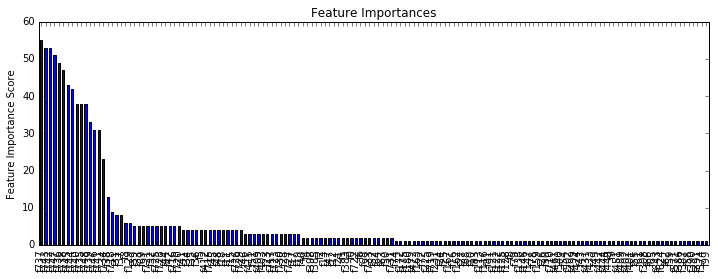

In [13]:
#Create an Extreme Gradient Boosting classifier and feed it into the model fit
#function
boost =  xgb.XGBClassifier(
 learning_rate = 1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(boost, features_train, labels_train)

In [14]:
# Use the appropriate number of estimators to create the classifier
boost =  xgb.XGBClassifier(
 learning_rate = 1,
 n_estimators=33,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27).fit(features_train_1, labels_train_1)

In [15]:
# Evaluate on larger test set
boost_pred = boost.predict(features_test_1)

# Creates confustion matrix and prints it out
cm = metrics.confusion_matrix(labels_test_1, boost_pred)
print("Confusion matrix")
print(pd.DataFrame(cm))

#Creates and print out the precision, recall, f1, and auc scores 
report_rf = metrics.precision_recall_fscore_support(list(labels_test_1), 
                                                    list(boost_pred), average='binary')

print "\nprecision = %0.2f\nrecall = %0.2f\nF1 = %0.2f\nAUC Score = %0.2f\n" % \
        (report_rf[0], 
         report_rf[1], 
         report_rf[2], 
         metrics.roc_auc_score(list(labels_test_1.values), list(boost_pred)))

Confusion matrix
        0       1
0  805091  465661
1  435043  834847

precision = 0.64
recall = 0.66
F1 = 0.65
AUC Score = 0.65



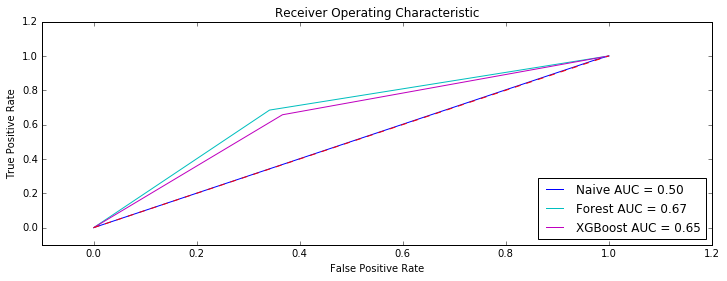

In [17]:
# Creating and plotting the ROC Curve
naive_false_positive_rate, naive_true_positive_rate, naive_thresholds = metrics.roc_curve(list(naive_labels_test), list(naive_pred))
naive_roc_auc = metrics.auc(naive_false_positive_rate, naive_true_positive_rate)

forest_false_positive_rate, forest_true_positive_rate, forest_thresholds = metrics.roc_curve(list(labels_test_1), list(forest_pred))
forest_roc_auc = metrics.auc(forest_false_positive_rate, forest_true_positive_rate)

boost_false_positive_rate, boost_true_positive_rate, boost_thresholds = metrics.roc_curve(list(labels_test_1), list(boost_pred))
boost_roc_auc = metrics.auc(boost_false_positive_rate, boost_true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(naive_false_positive_rate, naive_true_positive_rate, 'b',
label='Naive AUC = %0.2f'% naive_roc_auc)
plt.plot(forest_false_positive_rate, forest_true_positive_rate, 'c',
label='Forest AUC = %0.2f'% forest_roc_auc)
plt.plot(boost_false_positive_rate, boost_true_positive_rate, 'm',
label='XGBoost AUC = %0.2f'% boost_roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()